In [1]:
import os
from pathlib import Path

import pandas as pd
import seaborn as sb
import spacy
import wordcloud
from spacy import displacy
from fastlangid.langid import LID

In [38]:
ja_nlp = spacy.load("ja_core_news_sm")
ko_nlp = spacy.load("ko_core_news_sm")
zh_nlp = spacy.load("zh_core_web_sm")

In [39]:
# Max length in bytes of the text that can be passed into the parser
MAX_CHUNK_LEN = 49149

def collect_policies(path: Path | str) -> dict[str, list[str]]:
    raw_texts: list[str] = []

    for parent, _, files in os.walk(path):
        for filename in files:
            if filename.split(".")[-1] != "txt":
                continue
            with open(f"{parent}/{filename}", "r") as file:
                file_text = file.read()
                # Divide by 4 as one utf-8 character can be up to 4 bytes long.
                for chunk_start in range(0, len(file_text), MAX_CHUNK_LEN // 4):
                    raw_texts.append(
                        file_text[chunk_start : chunk_start + MAX_CHUNK_LEN // 4]
                    )

    classified: dict[str, list[str]] = {}
    classifier = LID()
    for text in raw_texts:
        lang = classifier.predict(text)
        try:
            classified[lang].append(text)
        except KeyError:
            classified[lang] = []
    return classified

In [40]:
pols = collect_policies(Path("../crawler/policies"))

In [41]:
pols.keys()

dict_keys(['zh-hant', 'zh-hans', 'en', 'ja', 'ko'])

In [42]:
ko_docs = list(ko_nlp.pipe(pols["ko"], n_process=-1))
ja_docs = list(ja_nlp.pipe(pols["ja"], n_process=-1))
zh_docs = list(zh_nlp.pipe(pols["zh-hans"], n_process=-1))

In [66]:
def get_freqs(text: list[str]) -> dict[str, int]:
    freq = {}
    for entry in text:
        if freq.get(entry) is None:
            freq[entry] = 1
        else:
            freq[entry] += 1
    return freq

In [83]:
# Replace this with the path to the font to use on your system
font_path = "/usr/share/fonts/noto-cjk/NotoSansCJK-Regular.ttc"

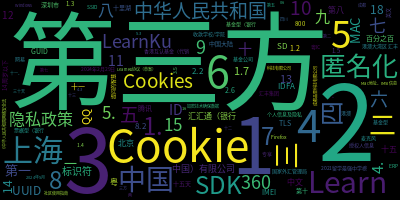

In [97]:
# Chinese
cloud=wordcloud.WordCloud(font_path=font_path)
freqs = get_freqs([str(ent) for doc in zh_docs for ent in doc.ents])
cloud.generate_from_frequencies(freqs)
cloud.to_image()

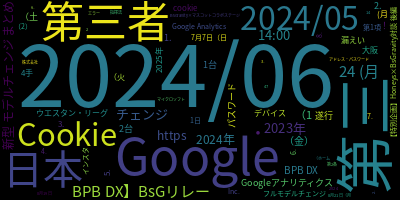

In [90]:
# Japanese
cloud=wordcloud.WordCloud(font_path=font_path)
freqs = get_freqs([str(ent) for doc in ja_docs for ent in doc.ents])
cloud.generate_from_frequencies(freqs)
cloud.to_image()

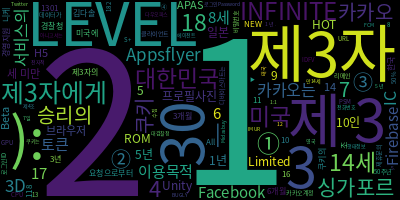

In [89]:
# Korean
cloud=wordcloud.WordCloud(font_path=font_path)
freqs = get_freqs([str(ent) for doc in ko_docs for ent in doc.ents])
cloud.generate_from_frequencies(freqs)
cloud.to_image()